<a href="https://colab.research.google.com/github/adrianmarino/neural-network-from-scratch/blob/master/Neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Neural Network From Scratch

This notebook implement a neural network micro-framework with a design Influenced by Keras framework abstractions. This makes it somewhat easier to introduce new changes. 

### 1. Import required libraries

In [0]:
import numpy as np
from math import pi, cos, sin, tanh
import pandas as pd

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import time
from abc import ABCMeta, abstractmethod

import matplotlib.pyplot as plt
from IPython.display import clear_output

### 2. External Utilities

**draw_neural_net**: this function was taken from: [craffel/draw_neural_net.py](https://gist.github.com/craffel/2d727968c3aaebd10359) github repository.

In [0]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            position = (n*h_spacing + left, layer_top - m*v_spacing)
            circle = plt.Circle(
                (n*h_spacing + left, layer_top - m*v_spacing), 
                v_spacing/4.,
                color= 'w',
                ec='k',
                zorder=4
            )
            ax.add_artist(circle)
            delta = (0.0003, 0.005)
            ax.annotate(
                'N' if n else 'I', 
                xy=(position[0] - delta[0], position[1] - delta[1]), 
                fontsize=10, 
                ha="center",
                zorder=5
            )
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

**Note:** Also take **generate_spiral_dataset** and **generate_two_spirals_dataset** functions from [Susros/spiralsdataset](https://github.com/Susros/spiralsdataset) github repository to generate spiral binary dataset.

In [0]:
"""
	The spiral dataset is generated based on Matt White's algorithm
	
	Author         : Kelvin Yin
	Python Version : 3.5.2
"""
def generate_spiral_dataset(density=1, maxRadius=6.5, c=0):
	""" To generate spiral dataset
	It generates one spirals dataset with x and y coordinates
	This generator generates points, each with 96 * density + 1 data points
	(3 revolutions of 32 times the density plus one end point).
	Args:
		density (int)  : Density of the points
		maxRadius (float) : Maximum radius of the spiral
		c (int) : Class of this spiral
	Returns:
		array: Return spiral data and its class
	"""
	
	# Spirals data
	spirals_data = []
	
	# Spirals class
	spirals_class = []

	# Number of interior data points to generate
	points = 96 * density 

	# Generate points
	for i in range(0, points):
		# Angle is based on the iteration * PI/16, divided by point density
		angle = (i * pi) / (16 * density)

		# Radius is the maximum radius * the fraction of iterations left
		radius = maxRadius * ((104 * density) - i) / (104 * density)

		# Get x and y coordinates
		x = radius * cos(angle)
		y = radius * sin(angle)
		
		# Format: 8.5f
		x = float(format(x, '8.5f'))
		y = float(format(y, '8.5f'))

		spirals_data.append([x, y])
		spirals_class.append([c])

	return spirals_data, spirals_class

def generate_two_spirals_dataset(density=1, maxRadius=6.5):
	""" To generate two spirals dataset
	It generates two spirals dataset with x and y coordinates
	
	First spiral dataset will be generated with the function
	`generate_spiral_dataset`.
	Then, the coordinates will be flipped to get second
	spiral dataset
	Args:
		density (int)  : Density of the points
		maxRadius (float) : Maximum radius of the spiral
	Returns:
		array: Return spirals data and its class
	"""

	# Spirals data
	spirals_data = []
	
	# Spirals class
	spirals_class = []

	# First spirals data and class
	first_spiral_data, first_spiral_class = generate_spiral_dataset(density, maxRadius)

	# Construct complete two spirals dataset
	for fsd in first_spiral_data:
		# First spirals coordinate
		spirals_data.append(fsd)

		# Second spirals coordinate
		spirals_data.append([-fsd[0], -fsd[1]])

	# Construct complete two spirals classes
	for fsc in first_spiral_class:
		# First spirals class
		spirals_class.append(fsc)

		# Second spirals class
		spirals_class.append([1])

	return spirals_data, spirals_class		

### 3. Helper classes used to plot a dataset, neural network, functions, etc...

In [0]:
class NetworkPlotter:
    def __init__(self, network): self.network = network

    def __layers_size(self):
        layers = []
        for index,layer in enumerate(self.network.layers):
            layers.append(layer.inputs)
            if index == len(self.network.layers) - 1:
               layers.append(layer.neurons)
        return layers

    def __topology(self):
        return pd.DataFrame(
             [(l.name(), l.inputs,l.neurons, l.act_fn.name()) for l in self.network.layers],
            columns=['Layer', 'Inputs', 'Neurons', 'Activation']
        )

    def plot(self):
        fig = plt.figure(figsize=(14, 14))
        ax = fig.gca()
        ax.axis('off')
        draw_neural_net(ax, .1, .9, .1, .9, self.__layers_size())
        fig.savefig('nn.png')
        return self.__topology()


In [0]:
class DatasetPlotter:
    @staticmethod
    def plot(X, Y):
        plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c='skyblue')
        plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c='salmon')
        plt.axis('equal')
        plt.grid()
        plt.show()

In [0]:
class LossesPlotter:
    @staticmethod
    def plot(summary):
        plt.plot(summary.epochs, summary.train_losses, label='Train Loss', c='b')
        plt.plot(summary.epochs, summary.val_losses, label='Validation Loss',c='g')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.legend()
        plt.show()

In [0]:
class FunctionPlotter:
    def __init__(self, function): self.function = function

    def plot(self, x_values):
        plt.title(f'{self.function.name()} Function')
        plt.grid()
        plt.plot(x_values, [self.function.compute(x) for x in x_values])
        plt.show()

### 4. Another common utils

In [0]:
def normal_rand_tensor(*dimensions):
    """Allow create a tensor with specified dimensions 
    and random values bethween -1 and 1.
    
    Examples: 
        - normal_rand_tensor(2): Create a two elements array. 
        - normal_rand_tensor(2, 2): Create (2, 2) matrix.
        - normal_rand_tensor(2, 2, 2): Create (2, 2, 3) tensor.
        - etc...
    """
    return np.random.rand(*dimensions) * 2 - 1

In [0]:
class TrainSummary:
    def __init__(self):
        self.epochs = []
        self.train_losses = []
        self.val_losses = []
        self.rows = []

    def add(self, epoch, train_loss, val_loss):
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.rows.append((epoch, train_loss, val_loss))

    def table(self):
        return pd.DataFrame(self.rows, columns=['Epoch', 'Train Loss', 'Validation Loss'])


### 5. Dataset

In [0]:
class Dataset:
    @staticmethod
    def circles(n_samples, factor, noise):
        X, Y = make_circles(n_samples=n_samples, factor=factor, noise=noise)
        # Change self.labels shape from (labels_count, ) to (labels_count, 1).
        #                                    Serie       to       Matrix
        Y = np.reshape(Y, (Y.shape[0], 1))
        return Dataset(X, Y)
    
    @staticmethod
    def spiral(density=1, max_radius=6.5):
        points, classes = generate_two_spirals_dataset(density, max_radius);
        return Dataset(np.array(points), np.array(classes))

    def __init__(self, X, Y): self.X, self.Y = X, Y

    def train_test(self, test_size, shuffle=True):
        return train_test_split(
            self.X, self.Y, test_size=test_size, shuffle=shuffle)

    def plot(self): DatasetPlotter.plot(self.X, self.Y)

## 6. Activation functions

In [0]:
# Abstract Class
class Function(metaclass=ABCMeta):
    @abstractmethod
    def compute(self, x): pass

    def derivate(self): return None
    
    def name(self): return self.__class__.__name__
    
    def plot(self, x_values): FunctionPlotter(self).plot(x_values)

In [0]:
class Sigmoide(Function):
    def compute(self, x): return 1 / (1 + np.e ** (-x))
    def derivate(self): return SigmoideDerivate()

class SigmoideDerivate(Function):
    def compute(self, x): return x * (1 -x)

In [0]:
class Tanh(Function):
    def compute(self, x): return np.tanh(x)
    def derivate(self): return TanhDerivate()

class TanhDerivate(Function):
    def compute(self, x): return 1 -np.tanh(x) ** 2

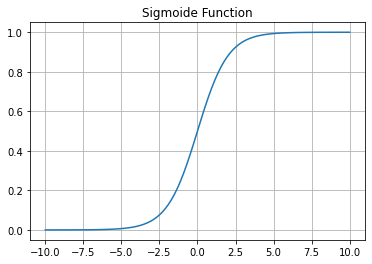

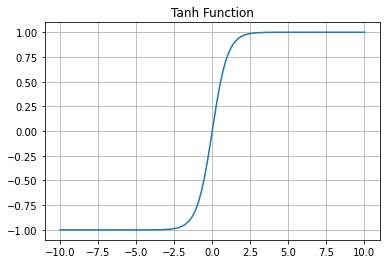

In [42]:
Sigmoide().plot(x_values=np.linspace(-10, 10, 100))
Tanh().plot(x_values=np.linspace(-10, 10, 100))

## 7. Neural network Layers

In [0]:
class LayerOutput:
    def __init__(self, weighted_sum, activation):
       self.weighted_sum = weighted_sum
       self.activation = activation

In [0]:
class DenseLayer:
    def __init__(self, inputs, neurons, act_fn):
        self.inputs = inputs
        self.neurons = neurons
        self.act_fn = act_fn
        self.biases = normal_rand_tensor(1, neurons)
        self.W = normal_rand_tensor(inputs, neurons)

    def name(self): return 'Dense'

    def compute(self, inputs):
        weighted_sum = inputs @ self.W + self.biases
        activation = self.act_fn.compute(weighted_sum)
        return LayerOutput(weighted_sum, activation) 

## 8. Neural network builder

A class used to construct a neural network.

In [0]:
class NetworkBuilder:
    def __init__(self): self.__layers = []
    
    def build(self): return Network(self.__layers)

    def resolve_inputs(self, default_inputs): 
        return self.__layers[-1].neurons if len(self.__layers) > 0 else default_inputs

    def layer(self, act, neurons, inputs=-1):
        inputs = self.resolve_inputs(inputs)
        layer = DenseLayer(inputs, neurons, act)
        self.__layers.append(layer)
        return self

## 9. Neural network callbacks

A callback allows perform any action after each training step like:
* Register metrics like train los or validation loss.
* Plot loss curves.
* Plot a graphic understand lerning process.



The neural network pass a context to each callback:

In [0]:
class TrainCallbackContext:
    def __init__(self, network, train_set, validation_set, loss_fn, update_interval, delay):
        self.summary = TrainSummary()
        self.loss_fn = loss_fn
        self.network = network
        self.train_set = train_set
        self.validation_set = validation_set
        self.update_interval = update_interval
        self.delay = delay

    def update(self, epoch, y_predicted):
        if epoch % self.update_interval == 0: 
            clear_output(wait=True)
            time.sleep(self.delay)
        self.epoch = epoch
        self.y_predicted = y_predicted

In [0]:
# Abstract Class
class TrainCallback(metaclass=ABCMeta):
    @abstractmethod
    def perform(self, context):
        pass
    def result(self):
        return None

**TrainSummaryCallback**: Register train and validation loos after each train step(epoch).

In [0]:
class TrainSummaryCallback(TrainCallback):
    def perform(self, ctx):
        train_loss = ctx.loss_fn.compute(ctx.y_predicted, ctx.train_set[1])

        val_y_pred = ctx.network.predict(ctx.validation_set[0])
        val_loss = ctx.loss_fn.compute(val_y_pred, ctx.validation_set[1])
        val_loss = np.mean(val_loss)

        ctx.summary.add(ctx.epoch, train_loss, val_loss)

**PlotLossesCallback**: Plot validation and train losses. Useful to detect overfiting, underfiting and the convergence progress.

In [0]:
class PlotLossesCallback(TrainCallback):
    def perform(self, ctx):
        if ctx.epoch % ctx.update_interval == 0:
            LossesPlotter.plot(ctx.summary)

**PlotLerningCallback:** Plot network perdiction after each epoch(training step).

In [0]:
class PlotLerningCallback(TrainCallback):
    def __init__(self, plot_samples=True, input_resolver=lambda x: x):
        self.__input_resolver = input_resolver
        self.__plot_samples = plot_samples

    def perform(self, ctx):
        if ctx.epoch % ctx.update_interval == 0:
            self.__plot_predictions(ctx)
            if self.__plot_samples:
                DatasetPlotter.plot(ctx.validation_set[0], ctx.validation_set[1])
            else:
                plt.show()

    def __plot_predictions(self, ctx):
            res = 50
            _x0 = np.linspace(-1.5, 1.5, res)
            _x1 = np.linspace(-1.5, 1.5, res)
            _Y = np.zeros((res, res))

            for i0, x0 in enumerate(_x0):
                for i1, x1 in enumerate(_x1):
                    X = np.array([[x0, x1]])
                    X = self.__input_resolver(X)
                    y_predicted = ctx.network.predict(X)
                    _Y[i0, i1] = y_predicted[0][0]

            plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
            plt.axis('equal')

## 10. Optimizers

This is responsible for adjusting W/b for each layer to perform the next gradient descent step.

In [0]:
# Abstract Class
class Optimizer(metaclass=ABCMeta):
    @abstractmethod
    def optimize(self, layers, outputs, errors, lr):
        pass

class BatchGradientDescent(Optimizer):
    def __init__(self, lr): self.__lr = lr

    def optimize(self, layers, outputs, errors):
        for layer_index in reversed(range(0, len(layers))):
            layer = layers[layer_index]    
            layer_error = errors[layer_index]
            layer_output = outputs[layer_index]

            mean_layer_error = np.mean(layer_error, axis=0, keepdims=True)            
            layer.biases = layer.biases - (mean_layer_error * self.__lr)

            delta = layer_output.activation.T @ layer_error
            layer.W = layer.W - delta * self.__lr

## 11. Neural Network

In [0]:
class Network:
    def __init__(self, layers): self.layers = layers

    @staticmethod
    def builder(): return NetworkBuilder()

    def plot(self): return NetworkPlotter(self).plot() 

    def __forward_pass(self, X):
        outputs = [LayerOutput(None, X)]
        for layer in self.layers:
            outputs.append(layer.compute(outputs[-1].activation))   
        return outputs

    def predict(self, X):
        outputs = self.__forward_pass(X)
        return outputs[-1].activation

    def __backward_propagation(self, loss_fn, outputs, Y):
        errors = [] # Or deltas
        for layer_index in reversed(range(0, len(self.layers))):
            layer = self.layers[layer_index]
            act_value = outputs[layer_index+1].activation

            if not errors: # Is last layer?
                first_term = loss_fn.derivate().compute(act_value, Y)
            else:
                previous_layer = self.layers[layer_index + 1]
                previous_error = errors[0]
                first_term = previous_error @ previous_layer.W.T

            second_term = layer.act_fn.derivate().compute(act_value)
            errors.insert(0, first_term * second_term)
        return errors 

    def train(
        self, 
        train_set, 
        validation_set, 
        loss_fn, 
        epochs, 
        optimizer, 
        callbacks = [], 
        interval=10,
        delay=0.1,
        val_loss_goal=0
    ):
        ctx = TrainCallbackContext(
            self, train_set, validation_set, loss_fn, interval, delay)

        for epoch in range(1, epochs + 1):
            outputs = self.__forward_pass(X=ctx.train_set[0])

            errors = self.__backward_propagation(
                loss_fn, outputs, ctx.train_set[1])

            optimizer.optimize(self.layers, outputs, errors)

            ctx.update(epoch, outputs[-1].activation)
            [c.perform(ctx) for c  in callbacks]

            if ctx.summary.val_losses[-1] <= val_loss_goal:
                break

        return ctx.summary

## 12. Loss functions

In [0]:
# Mean square error function

class MSEFunction(Function):
    def compute(self, Yp, Yr): return np.mean((Yp - Yr) ** 2)
    def derivate(self): return MSEDerivateFunction()

class MSEDerivateFunction(Function):
    def compute(self, Yp, Yr): return Yp - Yr



---



# Example 1: Train neural network to learn a circles dataset

,Layer,Inputs,Neurons,Activation
0,Dense,2,4,Sigmoide
1,Dense,4,8,Sigmoide
2,Dense,8,1,Sigmoide


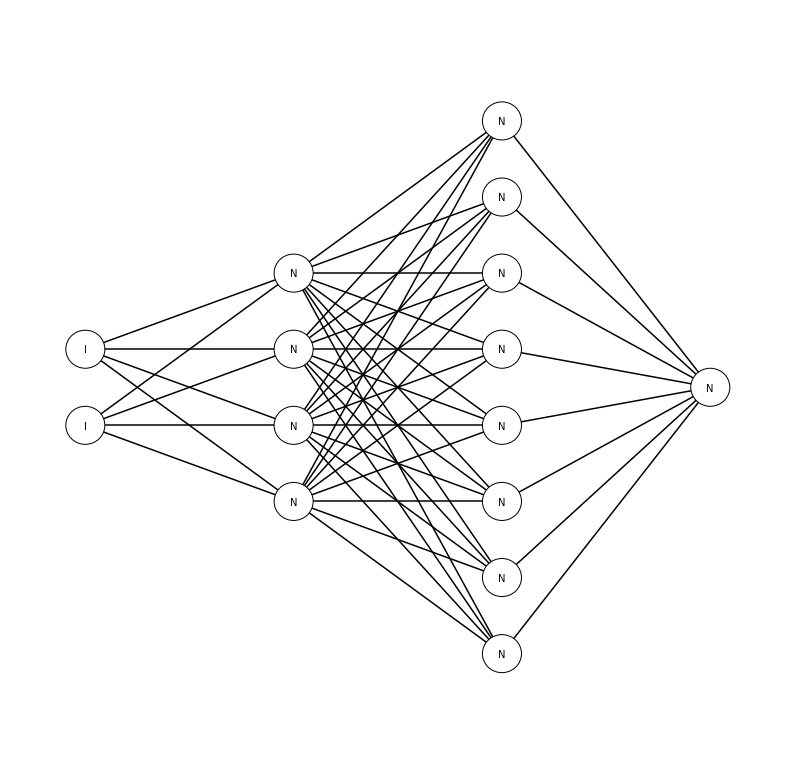

In [54]:
network = Network.builder() \
    .layer(act=Sigmoide(), neurons = 4, inputs = 2) \
    .layer(act=Sigmoide(), neurons = 8) \
    .layer(act=Sigmoide(), neurons = 1) \
    .build()

network.plot()

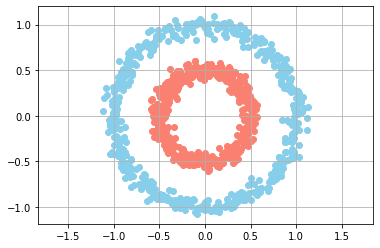

Train: 700 samples - Validation: 300 samples


In [55]:
circles_dataset = Dataset.circles(n_samples=1000, factor=0.5, noise=0.05)

circles_dataset.plot()

X_train, X_val, Y_train, Y_val = circles_dataset.train_test(test_size=0.3, shuffle=True)

print(f'Train: {len(X_train)} samples - Validation: {len(X_val)} samples')

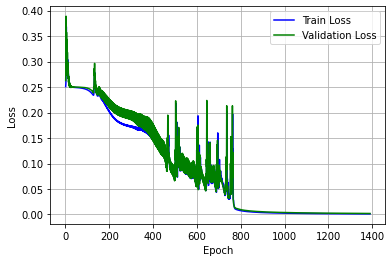

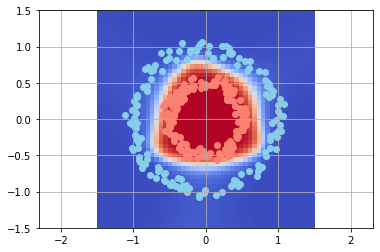

,Epoch,Train Loss,Validation Loss
0,1,0.250975,0.262804
1,2,0.257324,0.282509
2,3,0.294802,0.388959
3,4,0.368440,0.273020
4,5,0.283637,0.357482
...,...,...,...
1389,1390,0.001132,0.002007
1390,1391,0.001130,0.002005
1391,1392,0.001129,0.002002
1392,1393,0.001127,0.002000


In [56]:
summary = network.train(
    train_set=(X_train, Y_train),
    validation_set=(X_val, Y_val),
    epochs=5_000,
    loss_fn=MSEFunction(),
    optimizer=BatchGradientDescent(lr=0.04),
    callbacks=[
        TrainSummaryCallback(), 
        PlotLossesCallback(),
        PlotLerningCallback()
    ],
    val_loss_goal=0.002
)

summary.table()



---



# Example 2: Train a neural network to learn an spiral dataset

,Layer,Inputs,Neurons,Activation
0,Dense,6,30,Sigmoide
1,Dense,30,20,Sigmoide
2,Dense,20,10,Sigmoide
3,Dense,10,1,Sigmoide


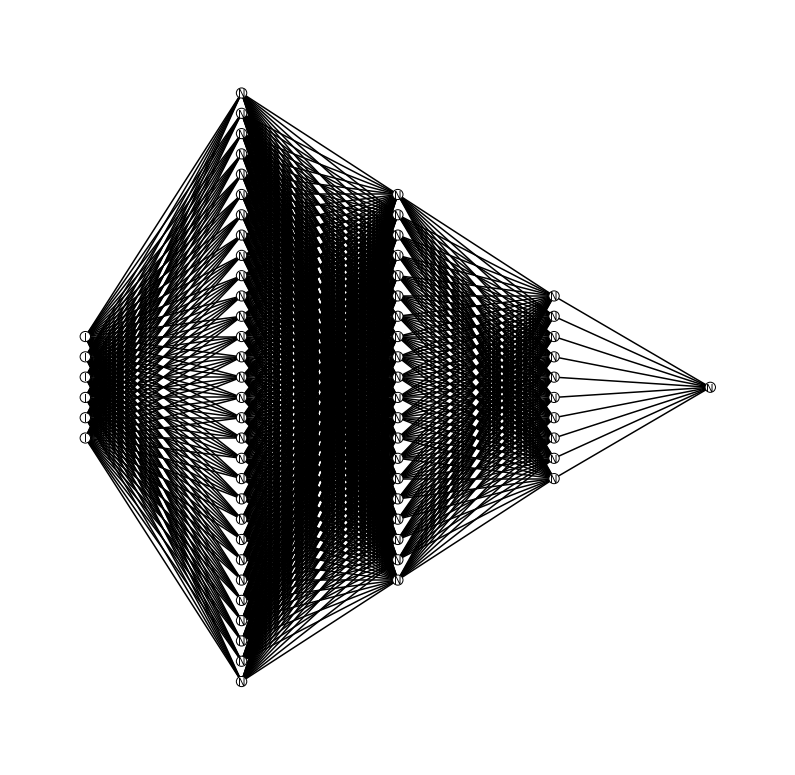

In [57]:
network = Network.builder() \
    .layer(act=Sigmoide(), neurons = 30, inputs = 6) \
    .layer(act=Sigmoide(), neurons = 20) \
    .layer(act=Sigmoide(), neurons = 10) \
    .layer(act=Sigmoide(), neurons = 1) \
    .build()

network.plot()

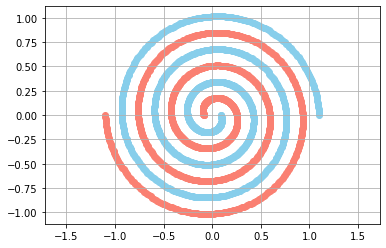

In [58]:
spiral_dataset = Dataset.spiral(density=10, max_radius=1.1)
spiral_dataset.plot()

Split dataset samples in two sets: train and validation. Validation set is used to check network results after each training step. Finally this information is uset to plot validation loss.

In [59]:
X_train, X_val, Y_train, Y_val = spiral_dataset.train_test(
    test_size=0.3, 
    shuffle=True
)

print(f'Train: {len(X_train)} samples - Validation: {len(X_val)} samples')
print(f'Train: {X_train.shape} - Validation: {X_val.shape}')

Train: 1344 samples - Validation: 576 samples
Train: (1344, 2) - Validation: (576, 2)


Add new feature columns(or inputs) as x1^2, x2^2, sin(x1) and sin(x2). This new columns help the model to make curves needed to learn the data spiral pattern.

In [60]:
def add_feature_columns(X):
    # Current X columns...
    x1 = X[:, [0]]
    x2 = X[:, [1]]
    # New columns...
    X2 = np.append(X,  x1**2, 1)
    X2 = np.append(X2, x2**2, 1)
    X2 = np.append(X2, np.sin(x1), 1)
    X2 = np.append(X2, np.sin(x2), 1) 
    return X2

X_train = add_feature_columns(X_train)
X_val = add_feature_columns(X_val)

X_train.shape, X_val.shape

((1344, 6), (576, 6))

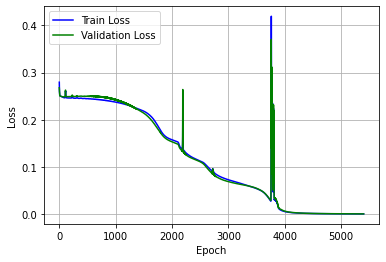

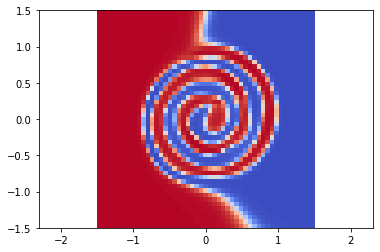

,Epoch,Train Loss,Validation Loss
0,1,0.279637,0.267910
1,2,0.268323,0.265271
2,3,0.265912,0.259424
3,4,0.259834,0.257424
4,5,0.257973,0.254797
...,...,...,...
5497,5498,0.000545,0.000605
5498,5499,0.000545,0.000605
5499,5500,0.000544,0.000605
5500,5501,0.000544,0.000604


In [61]:
callbacks = [
    TrainSummaryCallback(), 
    PlotLossesCallback(),
    PlotLerningCallback(
        plot_samples=False, 
        input_resolver=add_feature_columns
    )
]

summary = network.train(
    train_set=(X_train, Y_train),
    validation_set=(X_val, Y_val),
    epochs=10_000,
    loss_fn=MSEFunction(),
    optimizer=BatchGradientDescent(lr=0.01),
    callbacks=callbacks,
    delay=0,
    interval=150,
    val_loss_goal=0.000604
)

summary.table()